In [32]:
import numpy as np
import pandas as pd

In [137]:
TRAIN_DATA_PATH = "data/train.csv"
TEST_DATA_PATH = "data/test.csv"

## Explore the data

In [58]:
raw_df = pd.read_csv(TRAIN_DATA_PATH)
raw_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


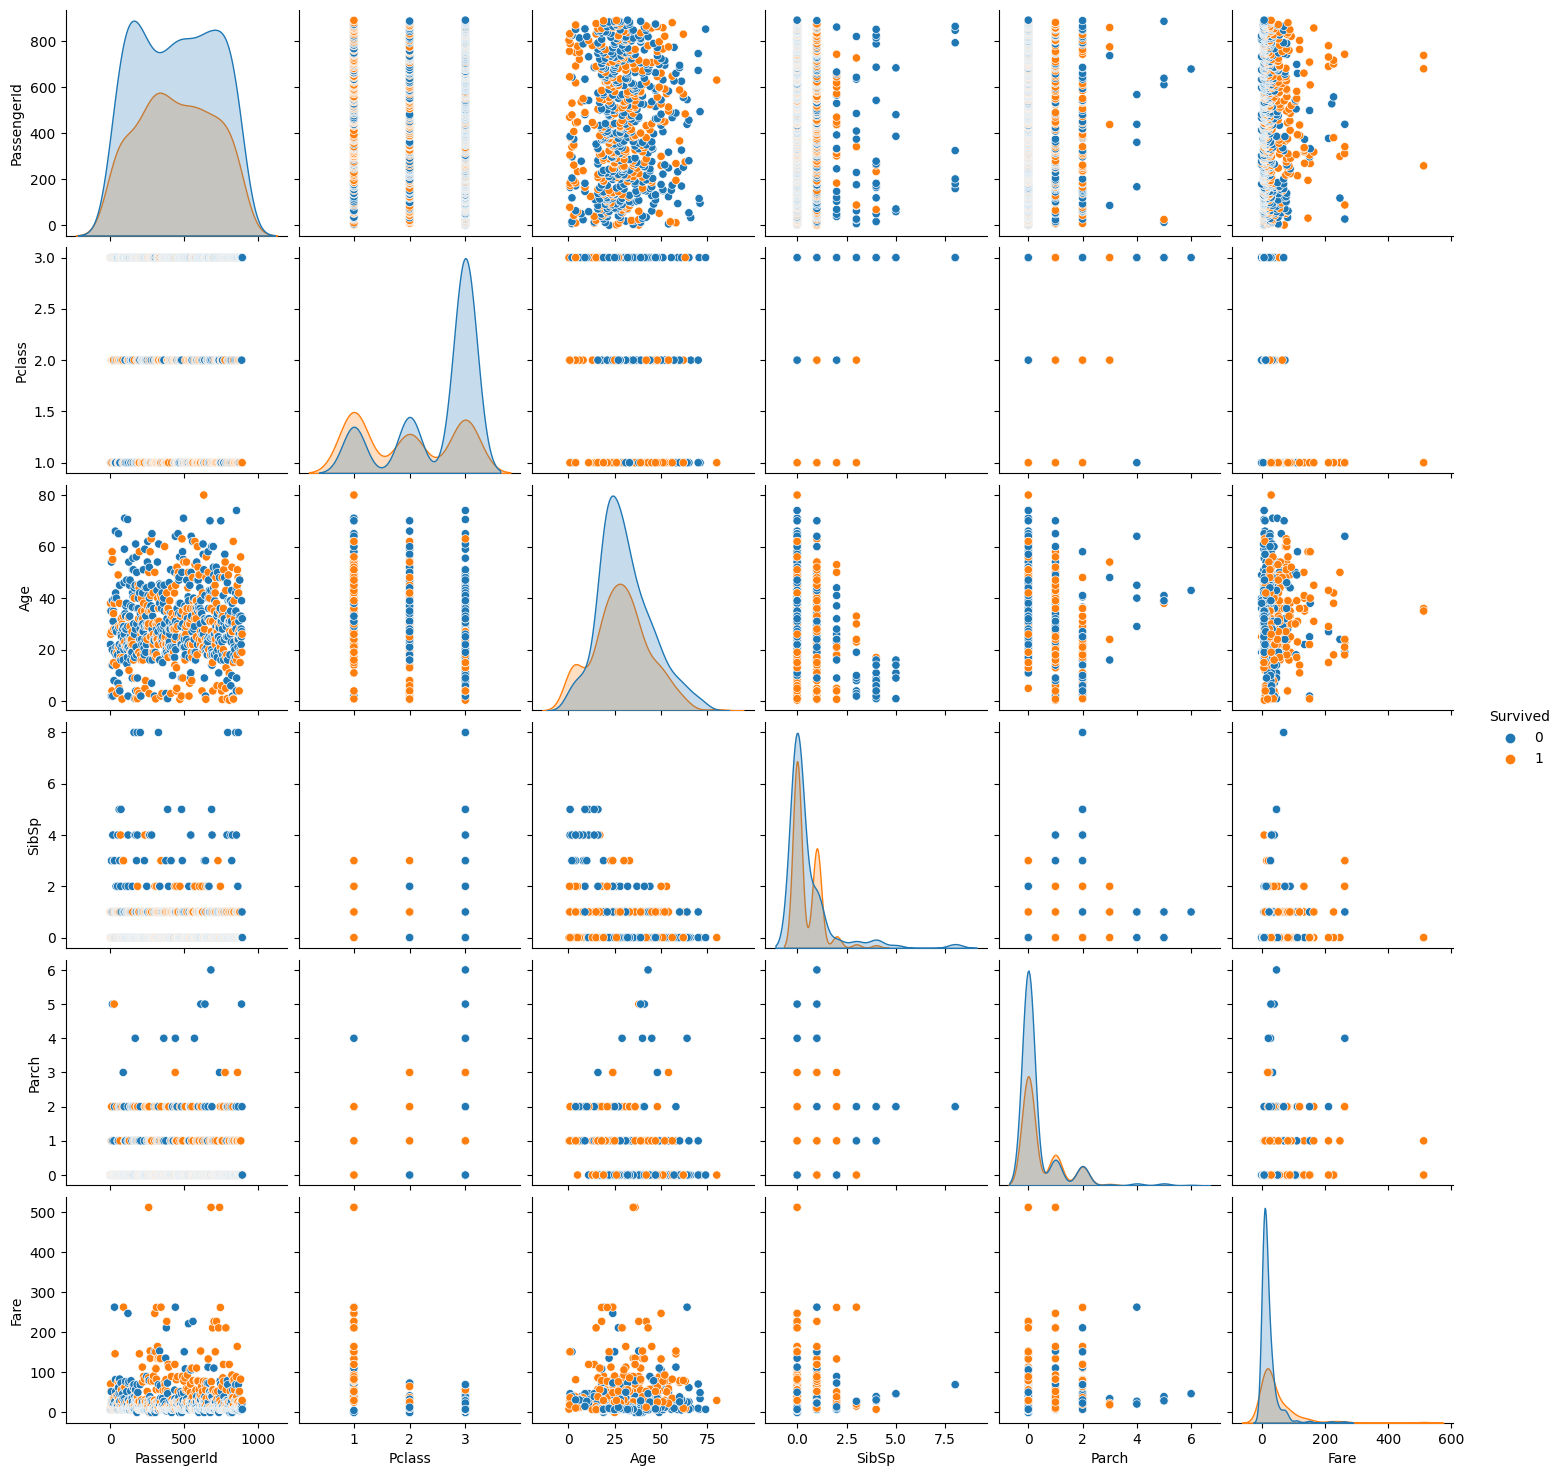

In [40]:
import seaborn as sns

sns.pairplot(raw_df, hue="Survived")

In [99]:
def drop_senseless_features(df):
    return df.drop(["PassengerId", "Name", "Cabin", "Ticket", "Embarked"], axis=1)

train_df = drop_senseless_features(raw_df)
train_df["Sex"] = train_df["Sex"].apply(lambda x: 1 if x == "male" else 0)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


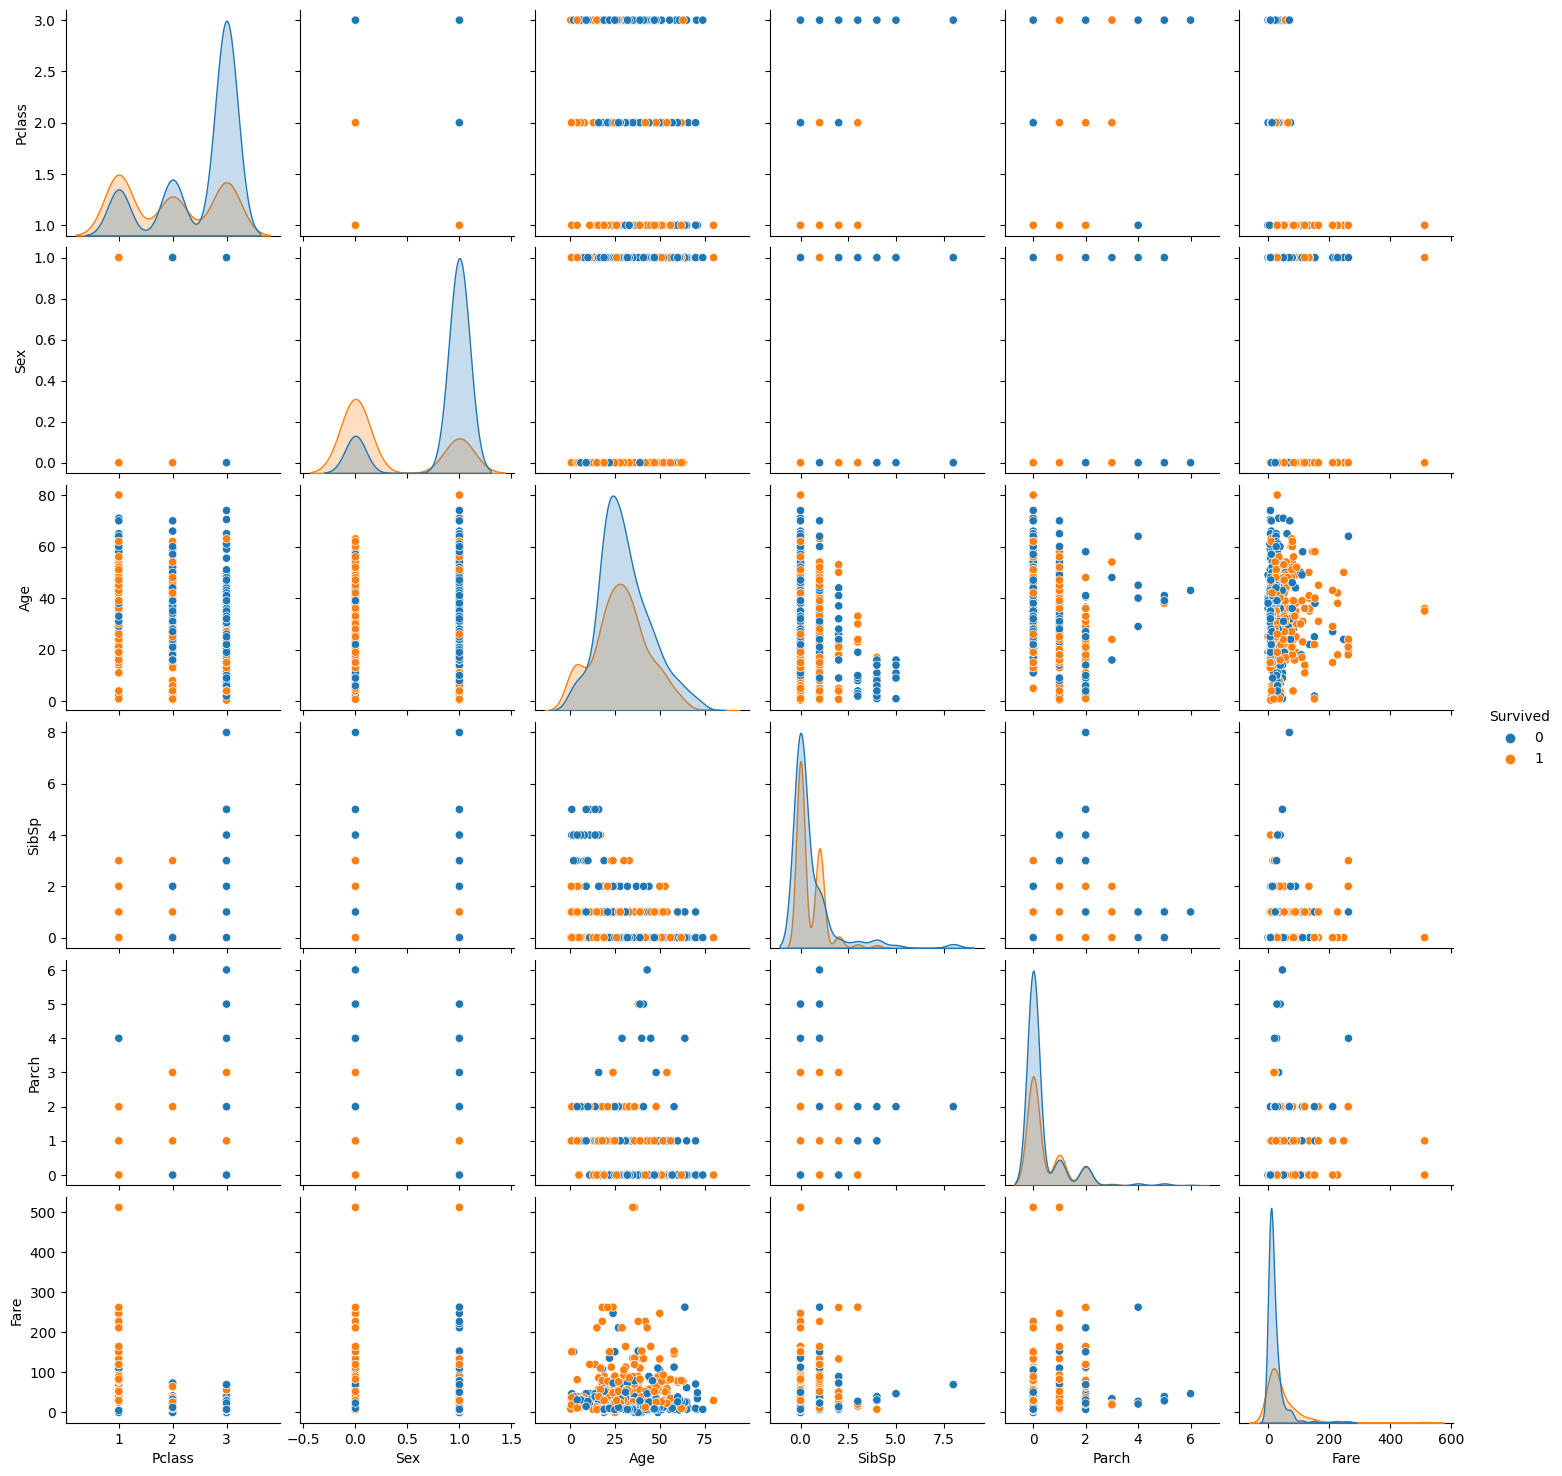

In [68]:
sns.pairplot(train_df, hue="Survived")

In [107]:
X_df, y_df = train_df.drop(["Survived"], axis=1), train_df["Survived"]

nan_mask = X_df.isna().any(axis=1)
X_df = X_df[~nan_mask]
y_df = y_df[~nan_mask]

In [108]:
X_df

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500
...,...,...,...,...,...,...
885,3,0,39.0,0,5,29.1250
886,2,1,27.0,0,0,13.0000
887,1,0,19.0,0,0,30.0000
889,1,1,26.0,0,0,30.0000


In [118]:
X, y = X_df.values, y_df.values
print(X.shape, y.shape)

(714, 6) (714,)


In [119]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel


selector = SelectFromModel(
    LinearSVC(
        C=0.01,
        penalty="l1",
        dual=False).fit(X, y),
    prefit=True,
    max_features=X.shape[1],
)

print(selector)

SelectFromModel(estimator=LinearSVC(C=0.01, dual=False, penalty='l1'),
                max_features=6, prefit=True)


In [116]:
selected_features = [feature for feature, selected in zip(X_df.columns, selector.get_support()) if selected]
print(selected_features)

['Sex', 'Age', 'SibSp', 'Fare']


## Train classifier

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate': (1e-3, 1e-2, 1e-1),
    'n_estimators': (10, 100, 1000),
    'max_depth': (2, 3, 4),
}

base_model = GradientBoostingClassifier()
model = GridSearchCV(base_model, parameters)
model.fit(X, y)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': (0.001, 0.01, 0.1),
                         'max_depth': (2, 3, 4),
                         'n_estimators': (10, 100, 1000)})

## Test the model

In [141]:
raw_df_test = pd.read_csv(TEST_DATA_PATH)
test_df = drop_senseless_features(raw_df_test)
test_df["Sex"] = test_df["Sex"].apply(lambda x: 1 if x == "male" else 0)
test_df = test_df.fillna(test_df.mean())
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,34.5,0,0,7.8292
1,3,0,47.0,1,0,7.0000
2,2,1,62.0,0,0,9.6875
3,3,1,27.0,0,0,8.6625
4,3,0,22.0,1,1,12.2875


In [142]:
X_test = test_df.values
print(test_df.shape)

(418, 6)


In [143]:
y_predicted = model.predict(test_df)

/Users/iolkhovsky/Documents/repos/kaggle_sandbox/titanic/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [146]:
ans = pd.DataFrame({
    'PassengerId': raw_df_test['PassengerId'],
    'Survived': y_predicted,
})
ans.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [148]:
ans.to_csv("ans.csv", index=False)